In [1]:
from zeno_client import ZenoClient, ZenoMetric
import pandas as pd
import json
import os
from dotenv import load_dotenv

load_dotenv(override=True)

False

In [2]:
import sys
sys.path.append('/home/jhsia2/ragged')

In [3]:
root_dir = '/data/tir/projects/tir6/general/afreens/dbqa'
results_dir = os.path.join(root_dir, 'reader_results')
# client = ZenoClient('zen_EZ7LuqItWgObcQmIvNZVytvhtTh8JMs2HrSzzfXsiIg')


In [5]:
with open('/data/tir/projects/tir6/general/afreens/dbqa/data/corpus_files/wiki_par_id2title.json', 'r') as file:
    # Use json.dump to write the list of dictionaries to the file
    id2title = json.load(file)

In [7]:
dataset = 'nq'

In [8]:
# datasets = ['nq', 'hotpotqa']
gold_data = []
# for dataset in datasets:
with open(os.path.join(root_dir, 'data/gold_zeno_files/', f"gold_{dataset.split('-')[0]}_zeno_file.json"), "r") as f:
    data = json.load(f)
for d in data:
    d['dataset'] = dataset
print(len(data))
gold_data = sorted(data, key=lambda x: x["id"])
# gold_answer_set, gold_wiki_par_id_set, gold_wiki_par_text_set, gold_title_set = get_gold_sets(gold_data)


2837


In [7]:
# wiki_par_id_set_size = []
# wiki_id_set_size = []
# for d in gold_data:
#     wiki_par_id_set_size.append(len(d['output']['wiki_par_id_set']))
#     wiki_id_set_size.append(len(d['output']['wiki_id_set']))
    
# import numpy as np

# import matplotlib.pyplot as plt
# def get_hist_info(size_set, unit):
#     print('avg', np.mean(size_set), 'std', np.std(size_set), 'min', np.min(size_set), 'max', np.max(size_set))
#         # gold_wiki_size = [len(s) for s in gold_wiki_par_id_set]

#     plt.hist(size_set, bins=np.arange(min(size_set)-0.5, max(size_set)+1.5, 1), edgecolor='black')

#     # Set the labels and title for the plot
#     plt.xlabel(f'gold {unit} set size')
#     plt.ylabel('frequency')
#     plt.title(f'gold {unit} set size - {dataset}')

#     # Set x-ticks to correspond to the integer values
#     plt.xticks(range(min(size_set), max(size_set) + 1))

#     # Display the plot
#     plt.show()
    
# get_hist_info(wiki_par_id_set_size, unit = 'paragraph')
# get_hist_info(wiki_id_set_size, unit = 'page')

In [9]:
def get_precision(guess_wiki_id_set, gold_wiki_id_set):
    precision = np.mean([[s in gold_wiki_id_set] for s in guess_wiki_id_set])
    return precision
def get_recall(guess_wiki_id_set, gold_wiki_id_set):
    # print(guess_wiki_id_set)
    # print(gold_wiki_id_set)
    recall = np.mean([[s in guess_wiki_id_set] for s in gold_wiki_id_set]) if len(gold_wiki_id_set) > 0 else 0.0
    return recall

In [10]:
import numpy as np
def get_reader_df(top_k, combined_data, return_df = True):
    results_dict =         {
            "question": [d['input'] for d in combined_data],
            "dataset": [d['dataset'] for d in combined_data],
            "id": [d['id'] for d in combined_data],
            "output": [
                json.dumps(
                    {   
                        "gold answer set": ', '.join(d['gold_answer_set']),
                        "gold title set": ', '.join(d['gold_title_set']),
                        # "gold context set": '\n'.join(d['gold_text_set']),
                        # "gold context": d['gold_context'],
                        "answer": d["output"]["answer"],
                        "retrieved context": [
                            {
                                # "wiki_id": None,
                                # "text": None,
                                # "score": None,
                                # "wiki_id_match": None,
                                # "wiki_par_id_match": None
                            }
                        ] if top_k == 'baseline' else [
                            {
                                "wiki_id": "[{idx}]({url})".format(
                                    idx=id2title[r["wiki_id"]],
                                    url="https://en.wikipedia.org/?curid="
                                    + r["wiki_id"],
                                ),
                                "text": r["text"],
                                "score": r["score"],
                                "wiki_id_match": r["wiki_id_match"],
                                "wiki_par_id_match": r["wiki_par_id_match"]
                            }
                        for r in d["output"]["retrieved"]
                        ],
                    }
                )
                for d in combined_data
            ],
            
            "gold wiki_par_id set size": [
                len(d["gold_wiki_par_id_set"]) for d in combined_data
            ],
            "max_score": [0 for d in combined_data] if top_k == 'baseline' else [
                d["output"]["retrieved"][0]["score"] for d in combined_data
            ],
            "avg_score": [0 for d in combined_data] if top_k == 'baseline' else [
                np.mean([r["score"] for r in d["output"]["retrieved"]]) for d in combined_data
            ],
            "f1": [
                d["output"]["answer_evaluation"]["f1"] for d in combined_data
            ],
            "exact_match": [
                d["output"]["answer_evaluation"]["exact_match"] for d in combined_data
            ],
            "substring_match": [
                d["output"]["answer_evaluation"]["substring_match"] for d in combined_data
            ],
            "any wiki_id_match": [False for d in combined_data] if top_k == 'baseline' else [
                d["output"]["summary context evaluation"]["wiki_id_match"] for d in combined_data
            ],
            "any wiki_par_id_match": [False for d in combined_data] if top_k == 'baseline' else [
                d["output"]["summary context evaluation"]["wiki_par_id_match"] for d in combined_data
            ],
            "precision wiki_id_match": [0 for d in combined_data] if top_k == 'baseline' else [
                get_precision(set([r["wiki_id"] for r in d["output"]["retrieved"]]), d['gold_wiki_id_set']) for d in combined_data
            ],
            "precision wiki_par_id_match": [0 for d in combined_data] if top_k == 'baseline' else [
                get_precision(set([r["wiki_par_id"] for r in d["output"]["retrieved"]]), d['gold_wiki_par_id_set']) for d in combined_data
            ],
            "recall wiki_id_match": [0 for d in combined_data] if top_k == 'baseline' else [
                get_recall(set([r["wiki_id"] for r in d["output"]["retrieved"]]), d['gold_wiki_id_set']) for d in combined_data
            ],
            "recall wiki_par_id_match": [0 for d in combined_data] if top_k == 'baseline' else [
                get_recall(set([r["wiki_par_id"] for r in d["output"]["retrieved"]]), d['gold_wiki_par_id_set']) for d in combined_data
            ]
        }
    if return_df:
        return pd.DataFrame(results_dict)
    return results_dict

In [11]:
def combine_gold_and_compiled(output_data, gold_data):
    
    for i, (od, gd) in enumerate(zip(output_data, gold_data)):
        # print(i)
        # print('output', od)
        # print('gold', gd)
        if(od['id'] != gd['id']):
            print(od, gd)
            break
        # od['gold_title_set'] = gd['output']['answer_set']
        od['dataset'] = gd['dataset']
        od['gold_answer_set'] = gd['output']['answer_set']
        od['gold_wiki_id_set'] = gd['output']['wiki_id_set']
        od['gold_wiki_par_id_set'] = gd['output']['wiki_par_id_set']
        od['gold_title_set'] = gd['output']['title_set']
    return output_data

retriever colbert
reader flanUl2
top50
reading from /data/tir/projects/tir6/general/afreens/dbqa/reader_results/flanUl2/nq/colbert/top50/reader_results_zeno.json
top5
reading from /data/tir/projects/tir6/general/afreens/dbqa/reader_results/flanUl2/nq/colbert/top5/reader_results_zeno.json


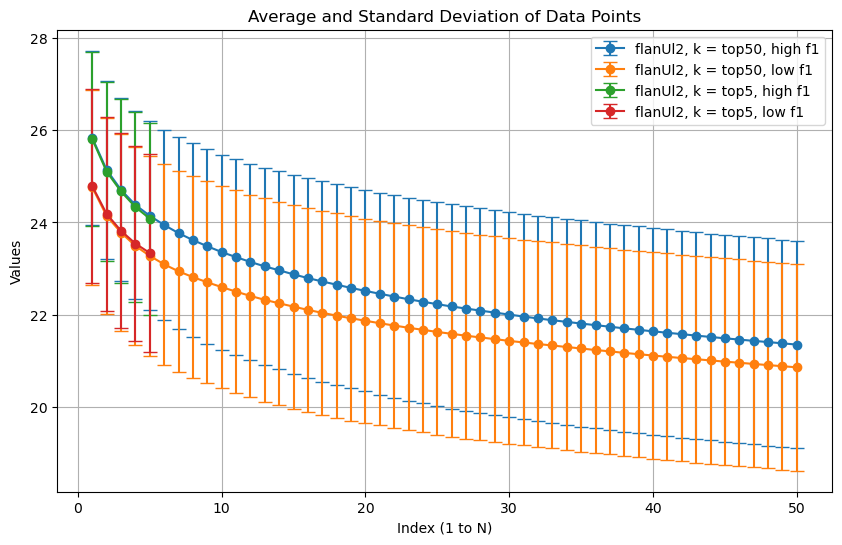

In [77]:
from file_utils import load_json
reader_models = ['flanT5', 'flanUl2', 'llama_7b', 'llama_70b']
# retriever_models = ['bm25', 'colbert']
retriever_models = ['colbert']
reader_models = ['flanUl2']
top_ks= ["top1", "top2", "top3", "top5", "top10", "top20", "top30", "top50"]
top_ks = ['top50', 'top5']

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

plt.figure(figsize=(10, 6))

f1_by_match = {}
i = 0
for retriever_model in retriever_models:
    for reader_model in reader_models:
    
        print('retriever', retriever_model)
        print('reader', reader_model)
        # reader_f1s = {'par match = V' : [], 'page match = V, par match = X' : [], 'par match = X' : []}
        # conditions = ['any wiki_par_id_match' == True, ]
        for top_k in top_ks:
            print(top_k)
            data = load_json(os.path.join(results_dir, reader_model, dataset, retriever_model, f"{top_k}/reader_results_zeno.json"))   
            combined_data = combine_gold_and_compiled(data, gold_data)
            output_df = get_reader_df(top_k, combined_data, return_df = True)
            high_scores = [[c['score'] for c in (json.loads(retrieved)['retrieved context'])] for retrieved in output_df.loc[output_df['f1'] > 0.9 ]['output']]
            low_scores = [[c['score'] for c in (json.loads(retrieved)['retrieved context'])] for retrieved in output_df.loc[output_df['f1'] < 0.1 ]['output']]
            data = np.array(high_scores)  # Replace 'your_matrix' with your actual matrix

            # Calculate the mean and standard deviation
            mean_values = np.mean(data, axis=0)
            std_dev_values = np.std(data, axis=0)

            # X-axis values (1 to N)
            x_values = np.arange(1, len(mean_values) + 1)

            # Plotting
            
            plt.errorbar(x_values, mean_values, yerr=std_dev_values, fmt='-o', capsize=5, color = colors[2*i], ecolor=colors[2*i], label=f'{reader_model}, k = {top_k}, high f1')

            data = np.array(low_scores)  # Replace 'your_matrix' with your actual matrix

            # Calculate the mean and standard deviation
            mean_values = np.mean(data, axis=0)
            std_dev_values = np.std(data, axis=0)

            # X-axis values (1 to N)
            x_values = np.arange(1, len(mean_values) + 1)

            plt.errorbar(x_values, mean_values, yerr=std_dev_values, fmt='-o', capsize=5, color = colors[i*2 + 1], ecolor=colors[i*2 + 1], label=f'{reader_model}, k = {top_k}, low f1')
            i+= 1

            # break
            # reader_f1s['par match = V'].append(np.mean(output_df.loc[output_df['any wiki_par_id_match'] == True]['f1']) if top_k != 'baseline' else np.mean(output_df['f1']))
            # reader_f1s['page match = V, par match = X'].append(np.mean(output_df.loc[(output_df['any wiki_par_id_match'] == False) & (output_df['any wiki_id_match']== True)]['f1']) if top_k != 'baseline' else np.mean(output_df['f1']))
            # reader_f1s['par match = X'].append(np.mean(output_df.loc[(output_df['any wiki_par_id_match'] == False) & (output_df['any wiki_id_match']== False)]['f1']))
            # break
        # break
        # f1_by_match[reader_model] = reader_f1s
    # break
plt.xlabel('Index (1 to N)')
plt.ylabel('Values')
plt.title('Average and Standard Deviation of Data Points')
plt.legend()
plt.grid(True)
plt.show()


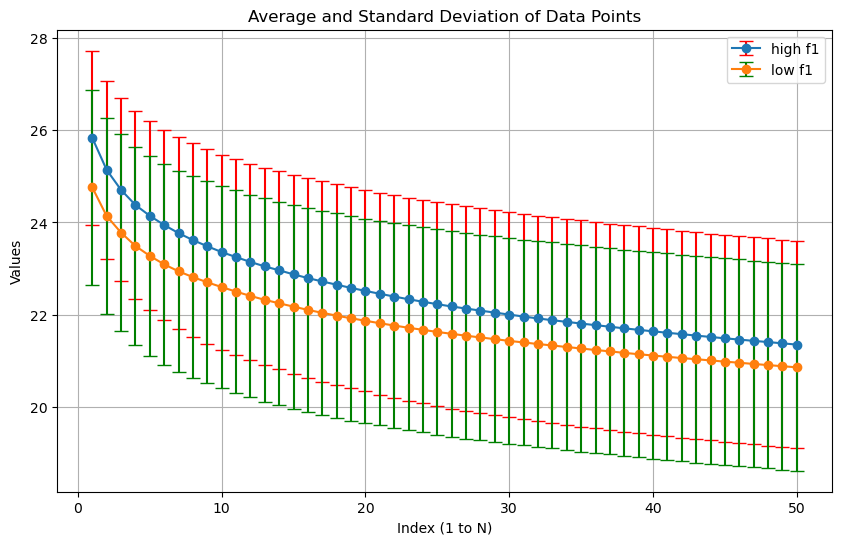

In [60]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming 'data' is your MxN matrix
data = np.array(high_scores)  # Replace 'your_matrix' with your actual matrix

# Calculate the mean and standard deviation
mean_values = np.mean(data, axis=0)
std_dev_values = np.std(data, axis=0)

# X-axis values (1 to N)
x_values = np.arange(1, len(mean_values) + 1)

# Plotting
plt.figure(figsize=(10, 6))
plt.errorbar(x_values, mean_values, yerr=std_dev_values, fmt='-o', capsize=5, ecolor='red', label='high f1')

data = np.array(low_scores)  # Replace 'your_matrix' with your actual matrix

# Calculate the mean and standard deviation
mean_values = np.mean(data, axis=0)
std_dev_values = np.std(data, axis=0)

# X-axis values (1 to N)
x_values = np.arange(1, len(mean_values) + 1)

plt.errorbar(x_values, mean_values, yerr=std_dev_values, fmt='-o', capsize=5, ecolor='green', label='low f1')


plt.xlabel('Index (1 to N)')
plt.ylabel('Values')
plt.title('Average and Standard Deviation of Data Points')
plt.legend()
plt.grid(True)
plt.show()


In [12]:
import matplotlib.pyplot as plt

In [64]:
colors[1]

'#ff7f0e'

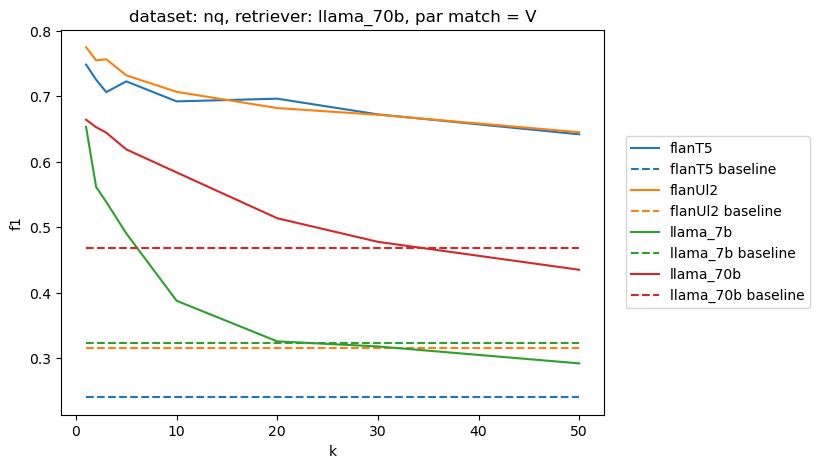

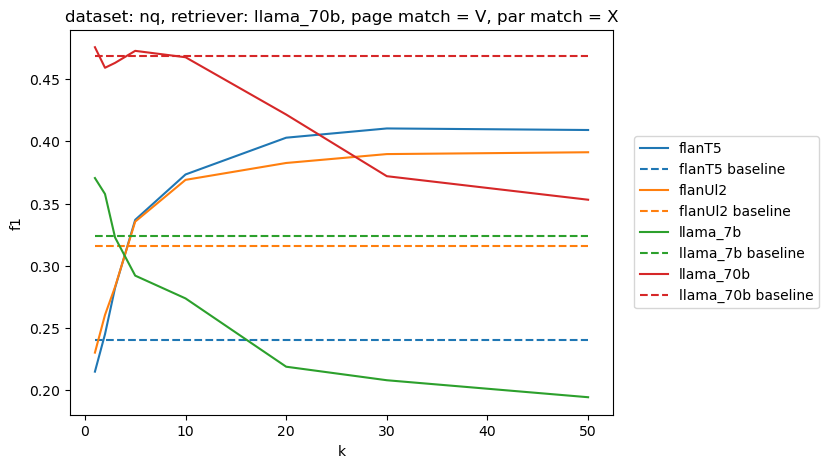

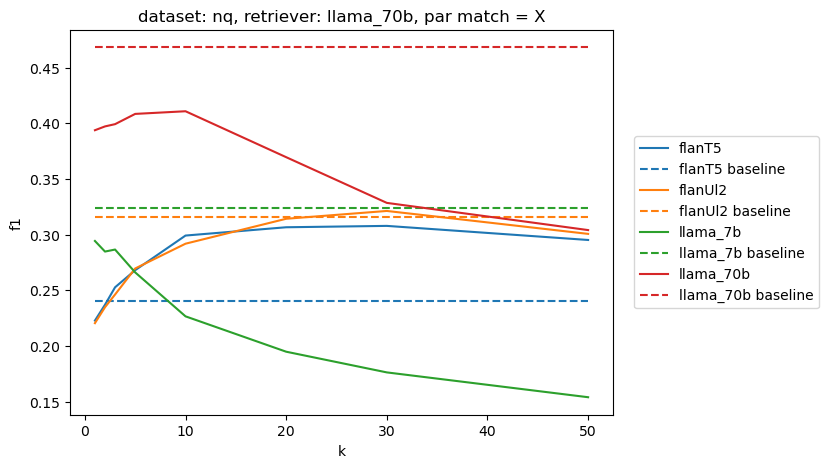

In [65]:
linestyles = ['-', '--', ':']
conditions = list(reader_f1s.keys())
# conditions
# colors = ['red','orange', 'green', 'blue']

for i, condition in enumerate(conditions):
    plt.figure(figsize=(7, 5))
    for j, reader in enumerate(reader_models):
        # print(f1_by_match[reader][condition][0])
        plt.plot([1, 2, 3, 5, 10 , 20 , 30 , 50], f1_by_match[reader][condition][1:], label = reader, color = colors[j], linestyle = linestyles[0])
        plt.hlines(y = f1_by_match[reader][condition][0], xmin = 1, xmax = 50, color=colors[j], linestyle='--', label = f'{reader} baseline')
    plt.title(f'dataset: {dataset}, retriever: {reader}, {condition}')

    # plt.ylim(bottom = 0.0, top = 1.0)
    plt.xlabel('k')
    plt.ylabel('f1')
    # plt.legend(loc = 'lower right')
    # plt.legen
    plt.legend(bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0)
    plt.savefig(f'{dataset}_{condition}.png')
    plt.show()
    # break

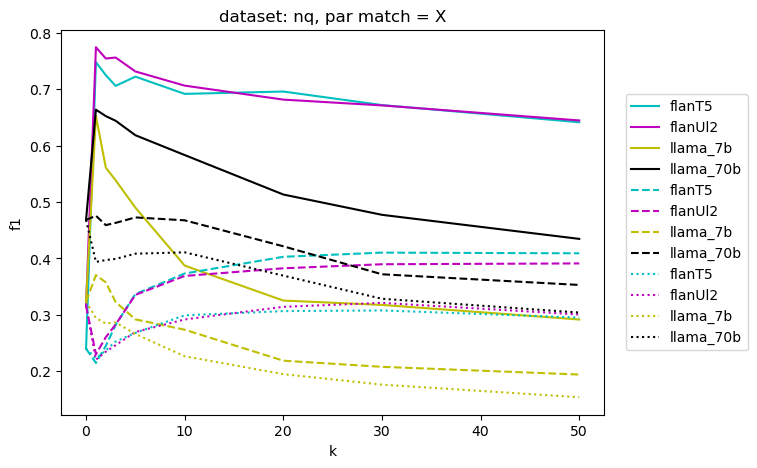

In [44]:
linestyles = ['-', '--', ':']
conditions = list(reader_f1s.keys())
# conditions
colors = 'cmyk'
plt.figure(figsize=(7, 5))
for i, condition in enumerate(conditions):
    
    for j, reader in enumerate(reader_models):
        # print(f1_by_match[reader][condition][0])
        plt.plot([0,1, 2, 3, 5, 10 , 20 , 30 , 50], f1_by_match[reader][condition], label = reader, color = colors[j], linestyle = linestyles[i])
        # plt.hlines(y = f1_by_match[reader][condition][0], xmin = 1, xmax = 50, color=colors[j], linestyle='--', label = f'{reader} baseline')
plt.title(f'dataset: {dataset}, {condition}')

# plt.ylim(bottom = 0.0, top = 1.0)
plt.xlabel('k')
plt.ylabel('f1')
plt.legend(bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0)
plt.show()
    # break

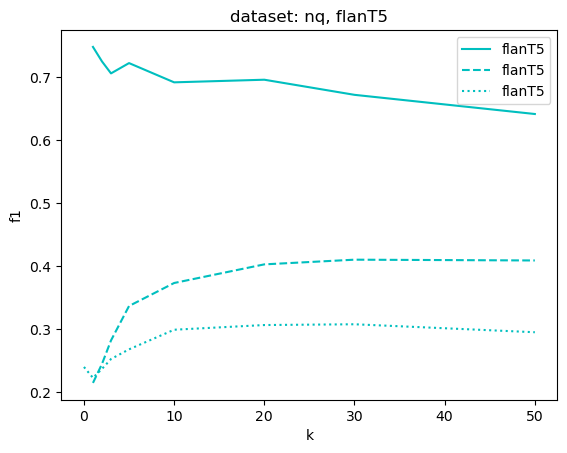

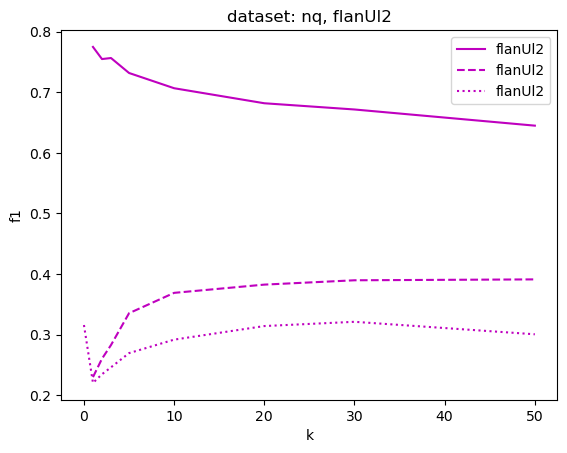

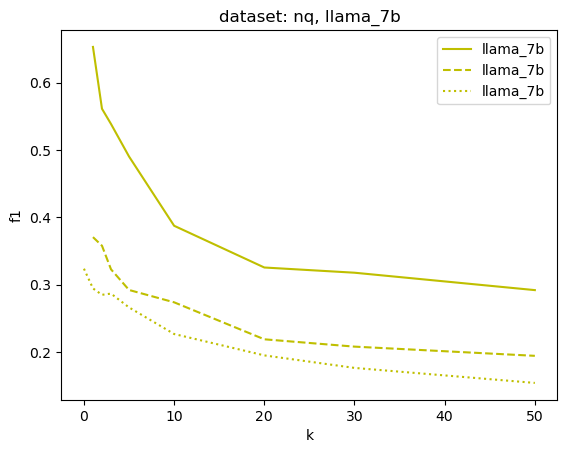

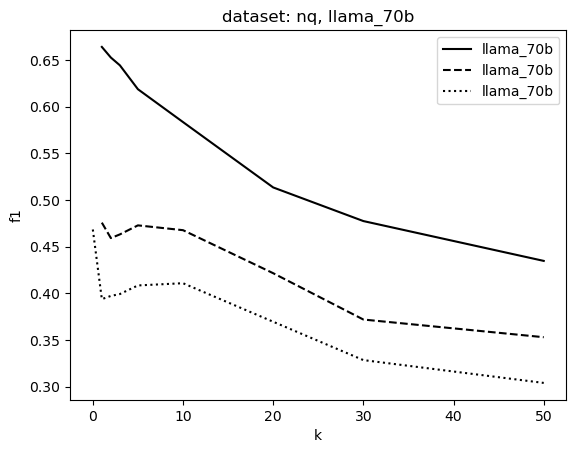

In [72]:
linestyles = ['-', '--', ':']
colors = 'cmyk'
for j, reader in enumerate(reader_models):
    for i, condition in enumerate(conditions):
        plt.plot([0, 1, 2, 3, 5, 10 , 20 , 30 , 50], f1_by_match[reader][condition], label = reader, color = colors[j], linestyle = linestyles[i])
    plt.title(f'dataset: {dataset}, {reader}')
    plt.xlabel('k')
    plt.ylabel('f1')
    # plt.ylim(bottom = 0.0, top = 1.0)
    # plt.xlim(left = 0.0, right = 1.0)
    plt.legend()
    plt.show()